# Nitrate and Phosphorus Loads from Illinois Rivers
To help enable reproducible cutting-edge science, data and workflows used in Illinois nutrient monitoring will be publically available. This notebook demonstrates the basic concepts of
1. making all data available from the cloud in analysis ready formats;
2. running notebooks locally or in the cloud to generate reports, run models, or create interactive web applets; and
3. enabling anyone to share, run, and modify notebooks using only a web browser.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/illinois-nutrient-monitoring/biennial-report/blob/master/notebooks/01_report_plots.ipynb)

# TODO
- scale total state load

## Environment Setup

In [30]:
#%%capture
#!pip install https://github.com/aleaf/Figures/archive/master.zip
#!pip install git+https://github.com/illinois-nutrient-monitoring/biennial-report.git

#!pip install -e /home/thodson/Desktop/Projects/illinois-nutrient-monitoring/biennial-report

In [1]:
%%capture
import matplotlib.pyplot as plt
from Figures import ReportFigures

%matplotlib inline
rf = ReportFigures()
rf.set_style()

# configure fonts for presentation
import matplotlib.pyplot as plt

In [2]:
# run for in-notebook presentation
SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

save_figures = True
figure_count = 0
# set figure dimensions
fig_w = 7.16 #5.51181
fig_h = 4.5

In [3]:
# load libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import xarray as xr
import pint_xarray
#from titlecase import titlecase

import warnings
warnings.filterwarnings("ignore", message="the unit of the quantity is stripped when downcasting to ndarray")

# load helper functions
from biennial_report.plot import *
from biennial_report.loads import *

### Configuration

In [4]:
mass_unit = 'pound'
area_unit = 'acre'
flow_unit = 'cubic feet per second'
nested = False #subtract nested gages
scale_total_load = 1.435 #rescale total to adjust for ungagged areas by assuming constant yield

## define study period
baseline_years = np.arange(1980,1996+1)
study_years = np.arange(2017,2021+1)

## Load Datasets

In [5]:
supergage_metadata = '../data/supergage_network.json'
ambient_metadata = '../data/ambient_network.json'

with open(supergage_metadata) as f:
    supergage_network = json.load(f)

with open(ambient_metadata) as f:
    ambient_network = json.load(f)

supergage_ds = xr.load_dataset('../data/illinois_supergage_annual_loads_continuous.nc').pint.quantify()
ambient_ds = xr.load_dataset('../data/illinois_ambient_annual_loads_wrtdsk.nc').pint.quantify()

labels(supergage_network, include_nested=nested)

['Embarras at Ste. Mairie',
 'Little Wabash at Carmi',
 'Big Muddy at Murphysboro',
 'Kaskaskia at Venedy Station',
 'Illinois at Valley City',
 'Rock at Joslin',
 'Green at Geneseo',
 'Vermilion at Danville']

### Convert Units

In [6]:
ambient_conversion = {}
for varname, da in ambient_ds.data_vars.items():
    if da.pint.units == 'kilogram':
        ambient_conversion[varname] = mass_unit
    elif da.pint.units == 'meter ** 3 / second':
        ambient_conversion[varname] = flow_unit

#ambient_conversion
ambient_ds = ambient_ds.pint.to(ambient_conversion)

supergage_ds = supergage_ds.pint.to({'nitrate nitrogen':mass_unit, 'total phosphorus':mass_unit})

supergage_ds

Magnitude,[[17634100.549600977 17559373.13980512 7130105.776419644 92259010.97455697 14407073.502372762 273739476.44870394 12518753.945851298 2683402.5481325616] [19074905.413750384 29215289.08268899 5136262.148575521 118873975.0849893 10563472.121472623 249725363.55339825 8215348.76796858 1892028.4508928908] [22411459.532601442 11997513.967820548 5347110.058411473 86202045.35342255 7963925.874314819 160127327.5744365 12203615.832025552 2580946.2734391177] [18558436.681029655 28318435.504397787 11865759.781432781 138010446.84217095 22577809.561151873 327349169.5501758 18108758.834616028 3425673.927273698] [16816655.194519464 17125104.541139144 5381417.857239376 104322624.8439922 9768581.633402873 257612707.21474275 15945247.833572024 3533301.476000697] [11633445.412811644 11803406.51437667 8214107.24148671 45537733.74353141 7109181.024433672 145126541.1655402 8049608.720519004 4025745.729006108]]
Units,pound
Magnitude,[[982219.5730515029 2197122.545469194 2958781.6957438984 3721358.288015151 545155.4658979331 22279329.125577316 5551626.241442561 1657903.1735726246] [703704.3005716391 2235247.9446469974 1693878.859976039 5431885.209155947 365523.17843420524 19127841.190734796 3749840.937233445 1030955.5581496875] [803416.5017388281 1687709.3507112577 2477665.2324523265 4201461.257108889 324891.4467946347 17094205.51670377 3766009.3468873953 1274718.9144273128] [1144721.0086673265 3052971.229750297 4438310.651017811 6896743.8465688145 1170478.1658863968 26440439.612365436 7533175.656778908 1798425.526795298] [889703.9298832031 3002080.9471758455 4316082.644498897 4901657.96408429 456554.4299775731 22879271.88682995 7773513.604286845 1453107.6689278742] [542818.6649241945 2009625.2181097078 3343877.0204462707 1817944.3287086328 255280.9472555669 16098551.742324863 5645580.051653303 1359445.7478077228]]
Units,pound


### Fill in missing data

In [7]:
# Add rock at rockton
rockton_id = '05437500'
rockton = ambient_ds.sel(site=rockton_id)[['nitrate nitrogen', 'total phosphorus']]
supergage_ds = xr.concat([supergage_ds, rockton], dim='site', join='inner')

# TODO fill in missing years or other state-border stations

### Compute drainage areas

In [8]:
from dataretrieval import nwis
site_df, _ = nwis.get_info(sites=gages(ambient_network, include_nested=True))
site_df = site_df[['site_no','dec_lat_va','dec_long_va','drain_area_va']]
site_ds = site_df.rename({'site_no':'site'}, axis=1).set_index('site').to_xarray()
site_ds = site_ds.pint.quantify({'drain_area_va':'square miles', 'dec_lat_va':'degrees', 'dec_long_va':'degrees'}).pint.to(drain_area_va=area_unit)

network = compute_network_loads(site_ds, ambient_network, subtract_nested=True)
network

Magnitude,[38.93643266 38.06055556 37.7583333 38.45055556 33.350839367999995 -0.8941666799999979 41.4889333 37.293809183700006]
Units,degree
Magnitude,[-88.0225351 -88.1572222 -89.3277778 -89.6275 -76.142139948 -1.1127777999999893 -90.1580083 -81.46543496700001]
Units,degree
Magnitude,[970236.1190438811 1985272.0588879415 1381754.4729655273 2811508.7539312467 14376979.291910311 2039031.8438481563 641917.4323225678 767804.9287710714]
Units,acre


### Compute loads from monitoring network

In [9]:
gages(ambient_network, include_nested=False)

['03345500',
 '03381500',
 '05599490',
 '05594100',
 '05586100',
 '05446500',
 '05447500',
 '03339000']

In [10]:
# scale loads based on state's contributing drainage

supergage_loads = compute_network_loads(supergage_ds, supergage_network, subtract_nested=True)
ambient_loads = compute_network_loads(ambient_ds, ambient_network, subtract_nested=True)

ambient_loads = ambient_loads.where(ambient_loads.year.dt.year >= baseline_years[0]).dropna(dim='year', how='all') # awkward
baseline_mean_load = ambient_loads.sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()
current_mean_load = ambient_loads.sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(study_years)).mean()

In [11]:
#supergage_loads.mean(dim='year')

## Methods
Replicates methods from previous biennial reports:
- baseline period: water years 1980–1996 
- current period: water years 2017–2022
- subtracts load for Rock River at Rockton
- rescales other rivers based on their drainage area within the State

but adds
- continuous water quality data


## Results
### Statewide Nitrate Yield

In [12]:
supergage_total_yield = supergage_loads.sum(dim='river')/network['drain_area_va'].sum()
ambient_total_yield = ambient_loads.sum(dim='river')/network['drain_area_va'].sum()


baseline_mean_yield = ambient_total_yield.sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

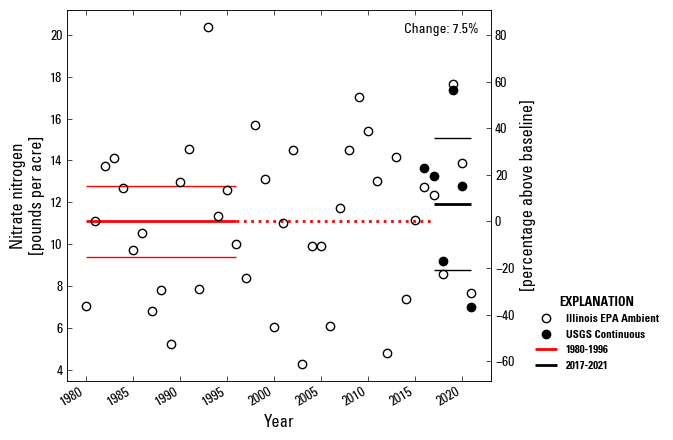

In [14]:
parameter='nitrate nitrogen'
loc='upper right'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))


running_average_plot(ds1=ambient_total_yield[parameter].assign_attrs({'label':'Illinois EPA Ambient'}),
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_yield[parameter].assign_attrs({'label':'USGS Continuous'}),
                     loc=loc,
                     ax=ax)

ax2 = percentage_scale(baseline_mean_yield[parameter].values, ax)

ax2.set_ylabel('[percentage above baseline]'.capitalize())
text = ax.set_ylabel(f'{parameter}\n[pounds per acre]'.capitalize())

ax.tick_params(bottom=True, top=True, left=True, right=False)
handles, labels = ax.get_legend_handles_labels()
rf.legend(ax, handles, labels, bbox_to_anchor=(1.25, 0))

fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1

### Statewide Phosphorus Yield

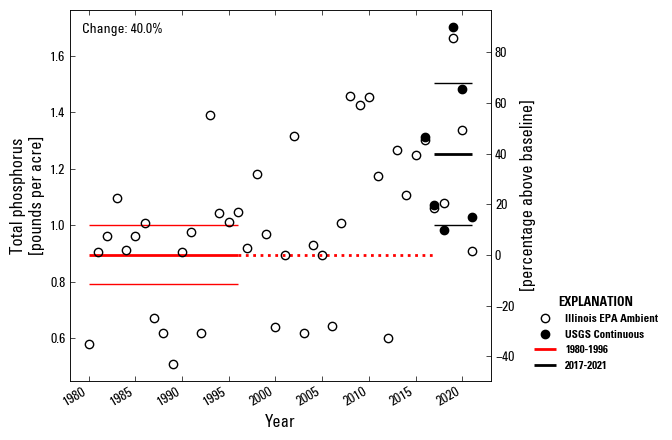

In [16]:
parameter='total phosphorus'
loc='upper left'

loc='upper left'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))


running_average_plot(ds1=ambient_total_yield[parameter].assign_attrs({'label':'Illinois EPA Ambient'}),
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_yield[parameter].assign_attrs({'label':'USGS Continuous'}), #comment this for ambient only
                     loc=loc,
                     ax=ax)

ax2 = percentage_scale(baseline_mean_yield[parameter].values, ax)

ax2.set_ylabel('[percentage above baseline]'.capitalize())
text = ax.set_ylabel(f'{parameter}\n[pounds per acre]'.capitalize())

ax.tick_params(bottom=True, top=True, left=True, right=False)
handles, labels = ax.get_legend_handles_labels()
rf.legend(ax, handles, labels, bbox_to_anchor=(1.25, 0))

fig.tight_layout()
if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1 

### Breakdown by River Basin

In [17]:
baseline_loads = ambient_loads.sel(year=ambient_loads.year.dt.year.isin(baseline_years))
current_loads = supergage_loads.sel(year=supergage_loads.year.dt.year.isin(study_years))

#current_loads = ambient_loads[['nitrate nitrogen','total phosphorus']].sel(year=ambient_loads.year.dt.year.isin(study_years))
#current_loads.pint.to('lb').groupby('river').mean(dim='year').to_dataframe()
x = current_loads.groupby('river').mean(dim='year').to_dataframe().sum()*scale_total_load
x.round()

nitrate nitrogen    427455019.0
total phosphorus     44915307.0
dtype: float64

In [18]:
# yield by river
baseline_yields = baseline_loads/network['drain_area_va']
current_yields = current_loads/network['drain_area_va']
current_yields.groupby('river').mean(dim='year').to_dataframe()
#baseline_yields.groupby('river').mean(dim='year').to_dataframe()

,nitrate nitrogen,total phosphorus
river,,
Embarras at Ste. Mairie,13.188366,1.605705
Little Wabash at Carmi,3.621132,1.639051
Big Muddy at Murphysboro,2.237401,1.001141
Kaskaskia at Venedy Station,3.764908,1.714258
Illinois at Valley City,13.320608,1.187702
Rock at Joslin,21.897617,0.949076
Green at Geneseo,18.065554,0.801576
Vermilion at Danville,21.437804,0.989433


In [19]:
#parameter = 'nitrate'
#fig, ax = plt.subplots(figsize=(fig_w, fig_h))
#
#mean = plot_by_basin(current_loads[parameter],
#              color='lightgreen',
#              ax=ax)
#
#ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
#ax.set_xlabel('Location'.capitalize())
##text = ax.set_ylabel(f'change in {parameter} load\n[percentage above baseline]'.capitalize())
#
#fig.tight_layout()

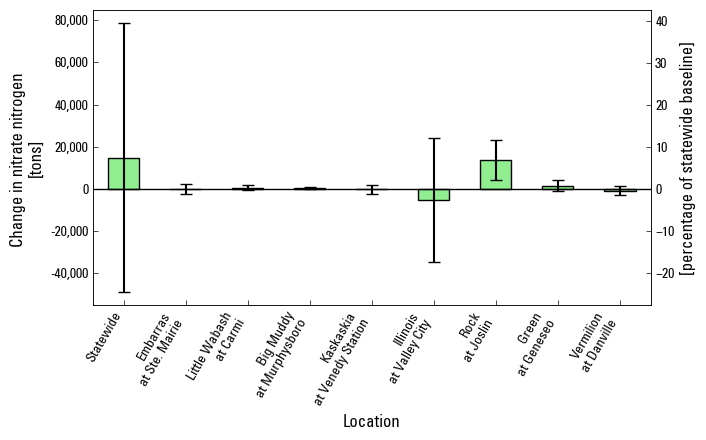

In [20]:
parameter = 'nitrate nitrogen'
mode='load'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter].pint.to('tons'),
                     current_loads[parameter].pint.to('tons'),
                     color='lightgreen',
                     mode=mode,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     ax=ax)


ax.set_xticklabels([label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
ax.set_xlabel('Location'.capitalize())
ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values * scale_total_load, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())
text = ax.set_ylabel(f'change in {parameter} \n[tons]'.capitalize())
format_yaxis(ax)
fig.tight_layout()


if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}_change.png', dpi=150)
    figure_count += 1

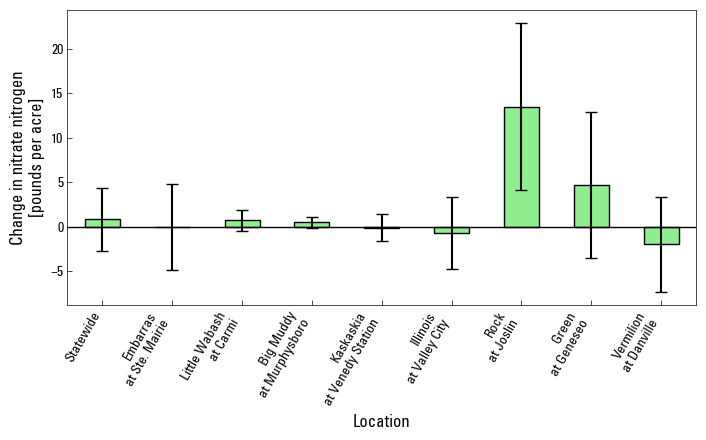

In [28]:
mode='yield'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lightgreen',
                     mode=mode,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(f'Change in {parameter}\n[pounds per acre]'.capitalize())
ax.set_xlabel('Location'.capitalize())
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}_change.png', dpi=150)
    figure_count += 1 

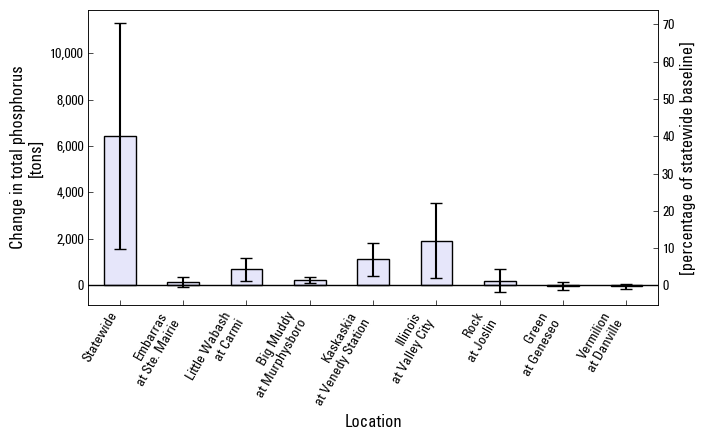

In [29]:
parameter = 'total phosphorus'
mode = 'load'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter].pint.to('ton'),
                     current_loads[parameter].pint.to('ton'),
                     color='lavender',
                     mode=mode,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     ax=ax)

ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values * scale_total_load, ax, diff=True)
#ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())

ax.set_xlabel('Location'.capitalize())
ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(f'change in {parameter}\n[tons]'.capitalize())
format_yaxis(ax)
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}_change.png', dpi=150)
    figure_count += 1

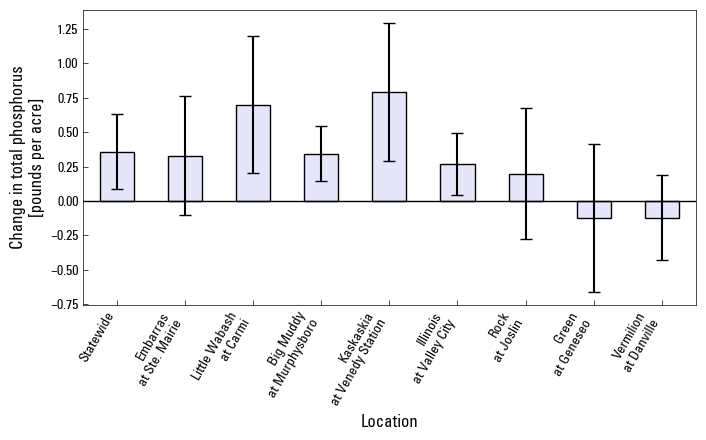

In [30]:
mode = 'yield'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter],
                     current_loads[parameter],
                     color='lavender',
                     mode=mode,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     ax=ax)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(f'Change in {parameter}\n[pounds per acre]'.capitalize())
ax.set_xlabel('Location'.capitalize())
fig.tight_layout()


if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}_change.png', dpi=150)
    figure_count += 1 

## Streamflow

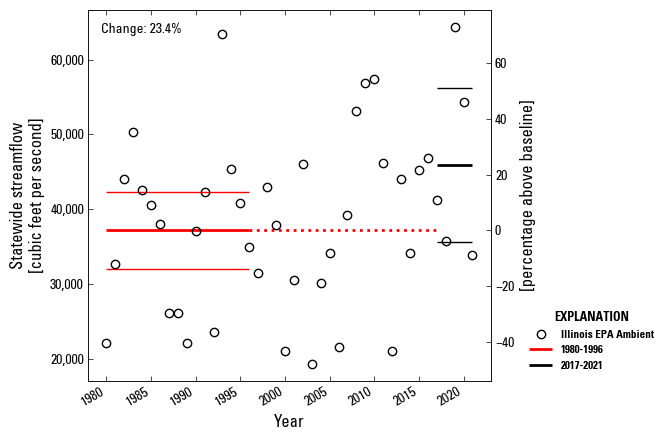

In [31]:
parameter = 'mean flow'
statewide_streamflow = ambient_loads[parameter].groupby('year').sum(dim='river').pint.to(flow_unit)
baseline_streamflow = statewide_streamflow.sel(year=statewide_streamflow.year.dt.year.isin(baseline_years)).mean()

#statewide_streamflow_p = statewide_streamflow / baseline_streamflow * 100 - 100

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=statewide_streamflow.assign_attrs({'label':'Illinois EPA Ambient'}),
                     period1=baseline_years,
                     period2=study_years,
                     loc='upper left',
                     ax=ax)


ax2 = percentage_scale(baseline_streamflow.values, ax)

ax2.set_ylabel('[percentage above baseline]'.capitalize())
#text = ax.set_ylabel(f'{parameter}\n[cubic meters per second]'.capitalize())

ax.tick_params(bottom=True, top=True, left=True, right=False)
handles, labels = ax.get_legend_handles_labels()
rf.legend(ax, handles, labels, bbox_to_anchor=(1.25, 0))


text = ax.set_ylabel(f'statewide streamflow\n[{flow_unit}]'.capitalize())
format_yaxis(ax)
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_annual_streamflow.png', dpi=150)
    figure_count += 1 

Change in streamflow yields by basin.

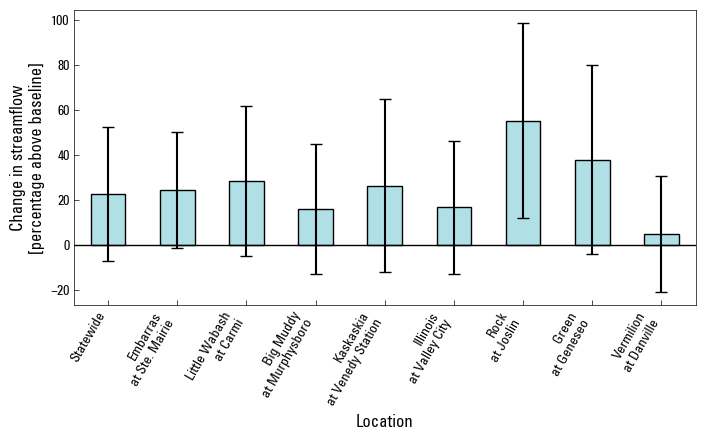

In [32]:
# TODO flawed logic
# select streamflow for baseline and current timeperiods
parameter='mean flow'
flow = append_total(ambient_loads[parameter])
pflow = flow/flow.mean(dim='year') * 100
baseline_streamflow = pflow.sel(year=pflow.year.dt.year.isin(baseline_years))
current_streamflow = pflow.sel(year=pflow.year.dt.year.isin(study_years))


#statewide_streamflow_p = statewide_streamflow / baseline_streamflow * 100 - 100
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_streamflow,
                     current_streamflow,
                     color='powderblue',
                     ax=ax,
                     compute_total=False,
                     da=network['drain_area_va'],
                     mode='load')

#percentage_scale(baseline_mean_flow.mean(), ax)
ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(f'Change in streamflow\n[percentage above baseline]'.capitalize())
ax.set_xlabel('Location'.capitalize())
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_streamflow_basin_change.png', dpi=150)
    figure_count += 1

## Flow-adjusted loads
Flow-adjusted nitrate loads by basin.

In [33]:
# compute flow adjustment factore
parameter = 'mean flow'
flow = ambient_loads[parameter]
pflow = flow/flow.mean(dim='year')

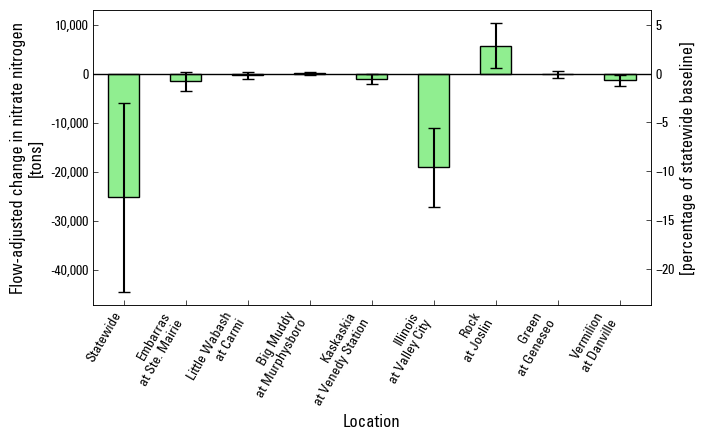

In [34]:
parameter = 'nitrate nitrogen'
mode = 'load'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

total_streamflow = ambient_loads['mean flow'].sum(dim='river')

plot_change_by_basin(baseline_loads[parameter].pint.to('ton')/pflow,
                     current_loads[parameter].pint.to('ton')/pflow,
                     color='lightgreen',
                     ax=ax,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     mode=mode)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')

text = ax.set_ylabel(f'flow-adjusted change in {parameter}\n[tons]'.capitalize())
#text = ax.set_ylabel(f'Change in flow-adjusted {parameter} load\n[percentage above baseline]'.capitalize())
ax.set_xlabel('Location'.capitalize())


ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values * scale_total_load, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())

format_yaxis(ax)
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_fa_{mode}.png', dpi=150)
    figure_count += 1

Flow-adjusted phosphorus load by basin

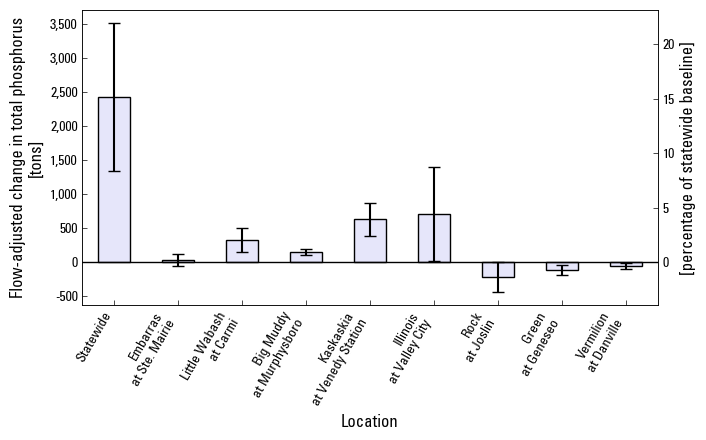

In [35]:
parameter = 'total phosphorus'
mode = 'load'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))


plot_change_by_basin(baseline_loads[parameter].pint.to('ton')/pflow, #total_streamflow,
                     current_loads[parameter].pint.to('ton')/pflow, #total_streamflow,
                     color='lavender',
                     ax=ax,
                     scale_total=scale_total_load,
                     da=network['drain_area_va'],
                     mode=mode)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(f'flow-adjusted change in {parameter}\n[tons]'.capitalize())
ax.set_xlabel('Location'.capitalize())

ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values * scale_total_load, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())

format_yaxis(ax)
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_fa_{mode}.png', dpi=150)
    figure_count += 1

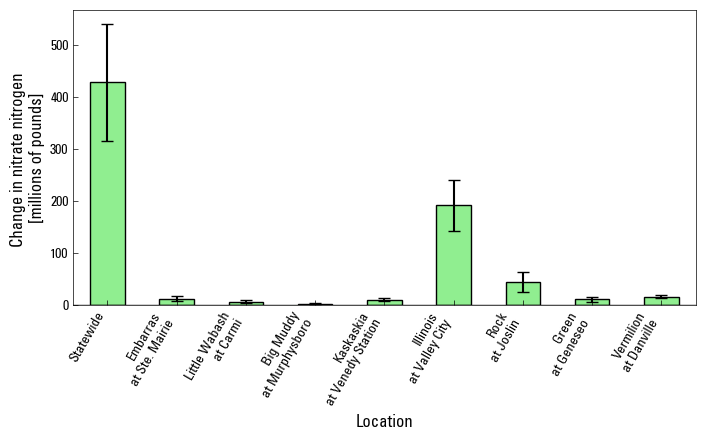

In [24]:
# plot statewide load
parameter = 'nitrate nitrogen'
mode = 'load'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

#plot_change_by_basin(current_loads[parameter].pint.to('tons')*0,
#                     current_loads[parameter].pint.to('lbs')/1e6,
#                     color='lightgreen',
#                     mode=mode,
#                     scale_total=scale_total_load,
#                     da=network['drain_area_va'],
#                     ax=ax)
#
plot_by_basin(current_loads[parameter].pint.to('lbs')/1e6,
              color='lightgreen',
              mode=mode,
              scale_total=scale_total_load,
              da=network['drain_area_va'],
              ax=ax)


ax.set_xticklabels([label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
ax.set_xlabel('Location'.capitalize())
#ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())
text = ax.set_ylabel(f'change in {parameter} \n[millions of pounds]'.capitalize())
format_yaxis(ax)
fig.tight_layout()


if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}.png', dpi=150)
    figure_count += 1

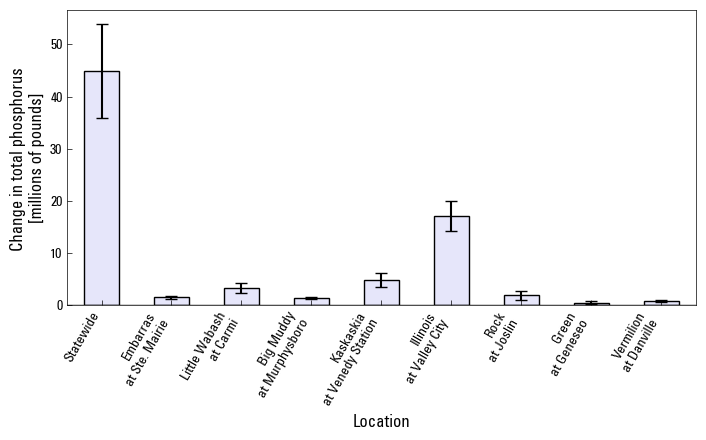

In [26]:
# plot statewide load
parameter = 'total phosphorus'
mode = 'load'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_by_basin(current_loads[parameter].pint.to('lbs')/1e6,
              color='lavender',
              mode=mode,
              scale_total=scale_total_load,
              da=network['drain_area_va'],
              ax=ax)


ax.set_xticklabels([label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
ax.set_xlabel('Location'.capitalize())
#ax2 = percentage_scale(baseline_mean_load[parameter].pint.to('tons').values, ax, diff=True)
ax2.set_ylabel('[percentage of statewide baseline]'.capitalize())
text = ax.set_ylabel(f'change in {parameter} \n[millions of pounds]'.capitalize())
format_yaxis(ax)
fig.tight_layout()


if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../figures/{fig_str}_{parameter}_basin_{mode}.png', dpi=150)
    figure_count += 1

# Mississippi River

In [64]:
# organize thebes and MARB series
#https://www.sciencebase.gov/catalog/item/62d86d7ed34e2842e1ed4f9b
sb_url = 'https://www.sciencebase.gov/catalog/file/get/62d86d7ed34e2842e1ed4f9b?f=__disk__44%2Fea%2Ffd%2F44eafd778c7fb0ddda193d7848bf339ffd974772'
df = pd.read_csv(sb_url, comment='#', dtype={'SITE_QW_ID':str, 'SITE_FLOW_ID':str})
df
#wrtdsk_load['year'] = pd.to_datetime(wrtdsk_load['year'], format='%Y').values


,SITE_ABB,SITE_QW_ID,SITE_FLOW_ID,CONSTIT,WY,MODTYPE,TONS,TONS_L90,TONS_U90,CONC,CONC_L90,CONC_U90
0,GILE,01054200,01054200,CHL,1966,WRTDS_FNG,197.0,130.0,298.0,0.921,0.638,1.47
1,GILE,01054200,01054200,CHL,1967,WRTDS_FNG,201.0,133.0,295.0,0.937,0.674,1.43
2,GILE,01054200,01054200,CHL,1968,WRTDS_FNG,206.0,139.0,293.0,0.957,0.717,1.41
3,GILE,01054200,01054200,CHL,1969,WRTDS_FNG,212.0,144.0,292.0,0.978,0.759,1.39
4,GILE,01054200,01054200,CHL,1970,WRTDS_FNG,219.0,154.0,301.0,1.010,0.805,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...
91318,GULF,GULF,GULF,TP,2017,WRTDS_K,155000.0,NaN,NaN,NaN,NaN,NaN
91319,GULF,GULF,GULF,TP,2018,WRTDS_K,160000.0,NaN,NaN,NaN,NaN,NaN
91320,GULF,GULF,GULF,TP,2019,WRTDS_K,282000.0,NaN,NaN,NaN,NaN,NaN
91321,GULF,GULF,GULF,TP,2020,WRTDS_K,226000.0,NaN,NaN,NaN,NaN,NaN


In [102]:
years = range(1980, 2022)
baseline_years = range(1980, 1997)
#  An exception to this rule is "GULF", which represents the combined annual flows to the Gulf of Mexico (based on the combined flows from the Mississippi River at Tarbert Landing and the Atchafalaya River at Simmesport)
gages = ['GULF']
#         '07381495', #Atchafalaya River at Melville, LA
#         '07373420', # MISSISSIPPI R NR ST. FRANCISVILLE, LA
#         '07022000',#thebes
#         '05586300'] #valley city

wrtdsk_df = df.query("MODTYPE == 'WRTDS_K'").query("WY in @years").dropna(how='all', axis=1)


gulf_df = wrtdsk_df.query("SITE_QW_ID in @gages")#.query("SITE_FLOW_ID != 'USACE-01100'")

#TODO verify which is used at 07373420 USACE-0110 or 1100?

#marb_df['KG'] = wrtdsk_df['TONS'] * 907.185


index = {'SITE_QW_ID' : 'site_no',
         'WY' : 'year'}

columns = {'SITE_QW_ID' : 'site_no',
           'WY' : 'year',
           'CHL': 'chloride',
           'TP': 'total phosphorus',
           'OP' : 'dissolved phosphorus',
           'TN' : 'total nitrogen',
           'NH3' : 'ammonia nitrogen',
           'SSC' : 'suspended sediment',
           'DOC' : 'dissolved organic carbon',
           'TDS' : 'total dissolved solids',
           'SI'  : 'dissolved silica',
           'NO3_NO2' : 'nitrate nitrogen'}
           
gulf_df = gulf_df.pivot(index=['SITE_QW_ID','WY'], columns='CONSTIT', values='TONS').reset_index().rename(columns=columns)#.rename(index=index).r#.to_xarray()

gulf_ds = gulf_df.set_index(['site_no','year']).to_xarray()
gulf_ds = gulf_ds.pint.quantify({key:'tons' for key in list(gulf_ds.keys())})

gulf_ds['year'] = pd.to_datetime(gulf_ds['year'], format='%Y').values

gulf_ds = gulf_ds.pint.to('pounds')

In [103]:
gulf_baseline = gulf_ds.sel(year=gulf_ds.year.dt.year.isin(baseline_years)).mean(dim='year')
#gulf_ds.pint.quantify('tons')
#baseline_loads
gulf_delta = gulf_ds - gulf_baseline

illinois = ambient_loads.sum(dim='river') * 1.34
illinois_baseline = illinois.sel(year=illinois.year.dt.year.isin(baseline_years)).mean(dim='year')
illinois_delta = illinois - illinois_baseline
#current_delta = cur
#compute illinois total

In [104]:
gulf_ds

Magnitude,[[29400000000.0 24200000000.0 30000000000.0 37000000000.0 34200000000.0 33400000000.0 31200000000.0 31400000000.0 24400000000.0 32400000000.0 33600000000.0 33200000000.0 28600000000.0 36600000000.0 33400000000.0 30400000000.0 29000000000.0 35800000000.0 31800000000.0 30800000000.0 21800000000.0 27400000000.0 31000000000.0 29600000000.0 31000000000.0 30800000000.0 22000000000.0 29800000000.0 34800000000.0 31400000000.0 35800000000.0 31800000000.0 25000000000.0 29400000000.0 28400000000.0 33600000000.0 34200000000.0 30800000000.0 31600000000.0 47200000000.0 40400000000.0 32400000000.0]]
Units,pound
Magnitude,[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 5920000000.0 8200000000.0 6900000000.0 6340000000.0 3600000000.0 5140000000.0 6200000000.0 5560000000.0 5920000000.0 5980000000.0 3140000000.0 5240000000.0 7200000000.0 6020000000.0 7800000000.0 6680000000.0 4600000000.0 5740000000.0 5240000000.0 6860000000.0 7200000000.0 5780000000.0 6060000000.0 11060000000.0 8620000000.0 5880000000.0]]
Units,pound
Magnitude,[[108800000.0 82400000.0 121600000.0 153200000.0 127000000.0 107200000.0 81200000.0 74600000.0 57000000.0 67200000.0 61600000.0 66200000.0 49800000.0 69200000.0 58800000.0 48000000.0 42800000.0 56800000.0 46400000.0 39200000.0 21600000.0 27800000.0 30400000.0 25000000.0 24600000.0 26800000.0 15000000.0 20800000.0 28200000.0 22000000.0 29800000.0 24600000.0 22200000.0 22400000.0 21400000.0 23800000.0 29600000.0 20400000.0 22600000.0 34400000.0 28800000.0 19220000.0]]
Units,pound
Magnitude,[[1886000000.0 1394000000.0 2000000000.0 2960000000.0 2500000000.0 2180000000.0 1846000000.0 1806000000.0 1214000000.0 2080000000.0 2200000000.0 2220000000.0 1622000000.0 2800000000.0 2300000000.0 2080000000.0 1936000000.0 2520000000.0 2220000000.0 1962000000.0 1184000000.0 1674000000.0 2040000000.0 1852000000.0 1950000000.0 1850000000.0 1212000000.0 1808000000.0 2340000000.0 2060000000.0 2440000000.0 2160000000.0 1400000000.0 1906000000.0 1748000000.0 2240000000.0 2220000000.0 1888000000.0 1884000000.0 3220000000.0 2520000000.0 1824000000.0]]
Units,pound
Magnitude,[[115600000.0 84800000.0 111000000.0 156800000.0 121000000.0 103800000.0 91000000.0 88200000.0 52600000.0 87400000.0 95200000.0 93600000.0 76800000.0 127600000.0 103400000.0 96600000.0 90200000.0 113800000.0 99000000.0 91400000.0 56400000.0 75000000.0 91200000.0 87800000.0 93400000.0 89400000.0 52000000.0 88000000.0 116600000.0 104600000.0 136600000.0 114400000.0 78400000.0 101800000.0 96400000.0 127200000.0 124200000.0 106800000.0 106000000.0 193200000.0 145800000.0 103400000.0]]
Units,pound
Magnitude,[[8940000000.0 6160000000.0 8920000000.0 13080000000.0 10900000000.0 10300000000.0 9020000000.0 9220000000.0 6400000000.0 10080000000.0 10820000000.0 11140000000.0 8000000000.0 13640000000.0 11300000000.0 9780000000.0 9000000000.0 12120000000.0 10240000000.0 9280000000.0 5400000000.0 7580000000.0 9280000000.0 8440000000.0 8980000000.0 9140000000.0 4900000000.0 8600000000.0 11660000000.0 10000000000.0 13300000000.0 11000000000.0 7840000000.0 9740000000.0 9140000000.0 12160000000.0 12960000000.0 10320000000.0 10880000000.0 21000000000.0 16300000000.0 11020000000.0]]


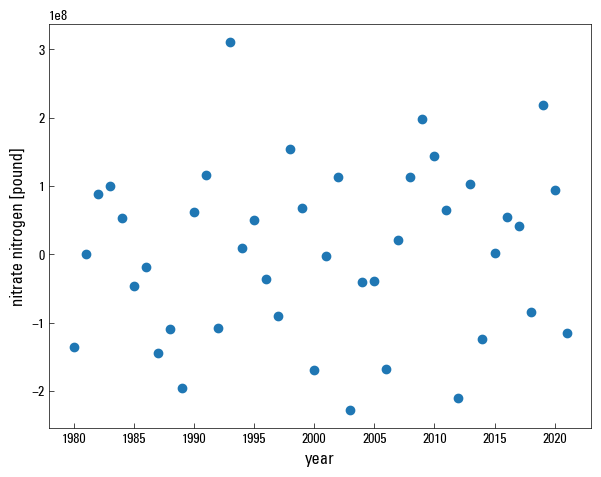

In [120]:
parameter = 'nitrate nitrogen'
#parameter = 'total phosphorus'

illinois_delta.plot.scatter(y=parameter, x='year')

In [121]:
percentage = (illinois_delta / gulf_delta) * 100

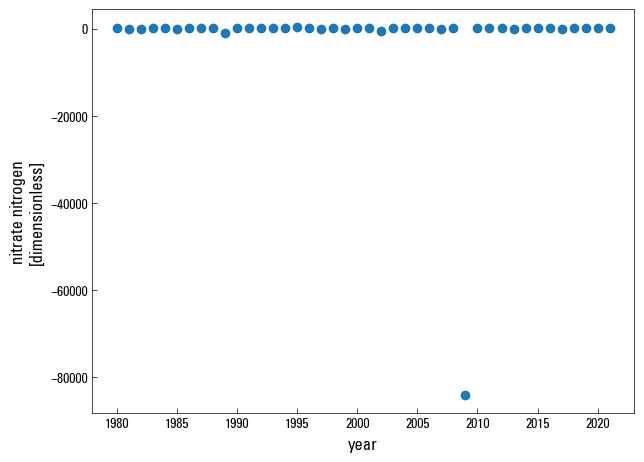

In [122]:

percentage.plot.scatter(y=parameter, x='year')

In [123]:
percentage['total phosphorus']

Magnitude,[[357.3205529353184] [-0.3858767147326354] [-10.612735031687288] [7.861556288862465] [1.9809776377095518] [17.27273942447009] [-24.894755385382712] [107.6797485963941] [9.54095033292334] [-116.66135372433546] [1.3267966313147652] [5.408424482601543] [26.515933506682654] [20.41046202942024] [15.032432002223292] [-16.937858754759052] [-12.281313472284845] [1.2142540656869323] [45.33970189084405] [19.279632340753786] [6.908671721055276] [0.006561835251968182] [27.64448835485406] [-54.26987878940723] [2.7415027235032734] [0.03699523906264549] [6.368512041322007] [355.7037698290552] [21.61190694767119] [57.24961600512154] [11.308515539843626] [19.73593370840705] [28.03663414864707] [72.42932230574903] [-755.5238525706684] [18.17179645164992] [12.42703688630942] [60.76243301493718] [31.98854197533707] [9.76157343043773] [9.807804381146905] [5.596895092868502]]
Units,dimensionless


Magnitude,[456126514.1779462 444295444.0256689 307898961.8334122 580910059.6055175 427672282.0987416 235006269.75143912]
Units,pound
Magnitude,[43872075.9318299 35825175.95400854 32937764.257160347 56942012.6075683 49554351.15545626 34449796.824680455]
Units,pound


In [71]:
baseline_loads - gulf_baseline

Magnitude,[[[nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [11729054.125896186] [11902707.84057397] [12693738.937503576] [15195510.958051454] [7470559.918861794] [20228317.2859004] [nan] [nan] [14107357.623373449]] [[nan] [1606010.433604801] [11544426.37300872] [16746536.23213179] [14994825.814251523] [13778435.666419014] [9739673.925342988] [1337832.1571492245] [7667964.981032482] [10092553.847022448] [8051705.342449938] [9971576.944346592] [4049104.5491429437] [12219642.051790971] [11872457.816747509] [9145963.188982937] [11913364.986327987]] [[-1123624.370437427] [181653.0088976794] [3654400.7757968446] [6400787.426877418] [5411474.842100031] [6327384.141897117] [2539381.4909706907] [-336500.10730222473] [793115.0138692353] [3248751.139318171] [1223894.17358041] [2503358.971456089] [-749546.2526772013] [2989454.6260192366] [4011493.9076764667] [3470702.1831595832] [4620313.033095176]] [[3205574.751673026] [3265982.756331481] [28451099.91339477] [25438693.68619126] [32709345.48308987] [24620625.119473524] [12474233.172889415] [3930432.028262577] [15896633.796603609] [8120975.004106726] [9925578.4854219] [22318197.104646027] [1249126.1897185994] [25510120.857684463] [26271934.20123784] [13325756.204460692] [17024771.7103873]] [[172400951.52487582] [270100012.5677236] [316450673.8612546] [331623113.66926986] [286965502.92859536] [261619238.76458398] [244559139.6672381] [182034624.40610173] [162987883.65074027] [109647178.37035821] [310454771.4672174] [355321243.55447936] [193435769.05498546] [443023077.24890417] [270005965.9672483] [290881176.368164] [193451213.66663095]] [[15283777.345777504] [15134786.920740165] [22651143.026994772] [32088013.625148788] [17279551.74559822] [10031269.130085967] [29059675.78075338] [10747937.732778735] [23049151.088726483] [8218122.714064895] [23636083.161680005] [23312174.34019786] [5969938.623137622] [43775857.095708035] [5366233.781277082] [30570082.955371432] [39128081.07601882]] [[nan] [5025696.571623393] [7803158.348592878] [8880510.68589079] [4587753.137962901] [4953026.47798844] [7916654.856481667] [7089151.4970226] [5429172.626566731] [-2179887.2215960566] [16888905.46995649] [10352758.047547247] [4961191.496284493] [21522724.99386074] [3519183.5542196827] [10496566.110279873] [8017200.000131241]] [[nan] [17249295.642083947] [23165045.908121273] [19786561.820084255] [22956468.125827447] [14065054.486087427] [21253231.058369722] [5596127.701009455] [9761512.561870322] [12611113.709261756] [25405837.94304902] [23325357.47773608] [10088678.471870083] [42198559.64006522] [24653643.730214264] [14267223.648677178] [14417533.716062136]]]
Units,pound
Magnitude,[[[nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan] [nan]] [[nan] [365744.8971328206] [1152106.0301474698] [1263344.122622438] [1334918.9597388562] [1326207.3052637158] [1216842.6129078898] [326420.09543917666] [892633.6761482173] [1502848.680426177] [1056230.76222795] [1209203.705754315] [426537.74071614636] [1252125.1287932429] [1047381.8479483734] [835229.0729799586] [1177099.3297481665]] [[256245.52438102593] [246613.1092678705] [513179.45384725573] [924840.0820893049] [618137.0835357798] [842357.6099965754] [500644.2121279119] [200452.87513518438] [283473.25310141867] [637624.9554327432] [469075.3830490631] [445552.05967393663] [203391.857552371] [629263.7257233458] [594528.6837736762] [830714.3806362579] [1009699.8648938524]] [[604926.7422771736] [281913.94556721125] [2820412.377540394] [2317982.673971968] [3146203.5499095414] [2217785.1772636347] [1588469.5430522393] [323004.8924894445] [1460611.7486188805] [1282622.3128618374] [910199.976921751] [1570524.7085745342] [310093.2114574201] [1478237.1332786798] [1534149.2730706257] [1231371.4287254927] [1176321.5168409518]] [[10873221.509228388] [11450604.054706391] [14859572.91544803] [10973796.330625847] [10223745.788109004] [8371800.636562476] [8555219.703333816] [6224361.588590835] [6799223.610189655] [5472834.484199728] [9008856.611

In [41]:
#baseline_loads[parameter].pint.to('tons')
#current_loads[parameter].pint.to('tons')

Magnitude,[[nan nan nan nan 987.2185239800223 749.2973592126342 526.7527758458549 173.71096872727387 343.8482111151915 417.4424274376575 498.77420777602606 487.30060208023355 319.5185911085763 1071.7373618961012 859.069168204924 472.49408097406945 1151.4939393711586] [nan 292.7177765357915 693.0790414309661 1364.5191827190574 1034.3637835001505 1140.338163095645 1026.4944271439138 266.9116656437586 671.3293259320038 846.8580170341053 909.6343044747426 995.0588675025556 487.91561462993764 1348.005368785194 1600.6787548035702 1059.662500495765 1196.2635526695483] [172.25256677046846 291.63507534308843 406.0207075352702 771.5262935309079 466.55250175394286 619.7968343250573 479.48721006925246 214.99996792274095 292.6355220657703 436.21069948773624 382.65987587048716 448.5423663541785 245.63150169391085 539.3340280393166 754.056643413116 549.7244916178817 642.7805652903731] [288.6773977260686 506.1922117428917 1663.9735915310928 1810.7248144407724 2277.926467325719 1437.9557464778347 1281.2297085156001 630.0288737220163 1517.4869012898084 748.3018508446254 1177.3770577313728 1198.5156187702191 427.6536221277269 1708.776373376828 2005.3091060592583 1662.9523882864262 1687.8751289401107] [6211.472538658446 8841.897053515257 8532.2557154125 8548.540924530987 5529.732395189983 6430.400943472662 7385.703595940119 5673.391404268994 3773.7231258982615 3297.332918100012 6206.827108665872 7353.107714311863 5348.348205239874 9301.010544776142 6892.755748514909 7254.312089508915 5871.586386252486] [478.4072756779399 876.3706607322346 1.672250351124444 503.2714284854487 440.27002702889376 947.0322549737778 984.7077895071296 964.7310315206583 645.9820190538039 356.9195509174904 799.2779949098352 887.0314882060301 553.9920678118993 1734.755536121563 108.53831161225196 977.0875114147095 1739.8417327875254] [109.14739372710353 201.17736989270793 262.0762117316922 312.1196461042765 201.64727418144187 296.45628739301776 377.9611306072015 277.45161365919813 232.46631110660007 29.8519792120842 756.8925266533918 300.80440947452456 152.5097633366276 759.8576558948736 148.6971992055334 257.22189727309575 384.36144770248245] [nan 302.33599928058766 451.57353473560426 365.8128371956524 473.25231010830294 401.7559222832608 506.94790864758176 191.26398080726102 252.75386367279515 234.52286091143915 583.9034944525193 541.4266804135177 188.7344141172393 891.2222534739732 666.5885076506029 397.83508417480675 383.3448110028837]]
Units,ton


## Summary
1. Nitrate load increased 7.5%, primarily from the Rock River
1. Phosphorus load increased 40%, primarily from the Illinois, Kaskaskia, and Little Wabash Rivers
1. Streamflow increased 23% statewide
1. Adjusting for streamflow, nitrate loads declined 10%
1. Adjusting for streamflow, phosphorus load increased 15%.


## References
U.S. Geological Survey, 2022, National Water Information System data available on the World Wide Web (USGS Water Data for the Nation), accessed [July 25, 2022], at URL [http://waterdata.usgs.gov/nwis/].